In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from numpy import linalg as ln #to compute eigen values/ vectors
import netCDF4 as nc

In [2]:
SST = nc.Dataset('sst.mon.ltm.1991-2020.nc', 'r') # read or write mode?

In [3]:
SST

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: COBE Sea Surface Temperature Analysis
    history: Created 2022/12/30 by doMonthLTMNC4
    platform: Analyses
    original_source: http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_catalog?projectname=NEAR-GOOS
    Conventions: CF-1.2
    institution: NOAA ESRL/PSD
    comment: recent values (w/i last year) may change as dataset is updated. It is a monitoring dataset.
    dataset_title: COBE Sea Surface Temperature
    References: https://www.psl.noaa.gov/data/gridded/data.cobe.html
    not_missing_threshold_percent: minimum 3% values input to have non-missing output value
    dimensions(sizes): lon(360), lat(180), time(12), nbnds(2)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float64 climatology_bounds(time, nbnds), float32 sst(time, lat, lon), int16 valid_yr_count(time, lat, lon)
    groups: 

In [4]:
# read in the variables
sst = SST.variables['sst'][:]
lat = SST.variables['lat'][:]
lon = SST.variables['lon'][:]
time = SST.variables['time'][:]
SST.close() #do I need this?

In [5]:
# Compute monthly climatology
monthly_climatology = np.mean(sst, axis=0)  # Adjust for seasonal periodicity
anomalies = sst - monthly_climatology

In [8]:
weights = np.sqrt(np.cos(np.radians(lat)))

# Expand dimensions of weights to match (time, lat, lon)
weights = weights[:, np.newaxis]  # Now weights.shape == (180, 1)

# Apply weights to anomalies
weighted_sst = anomalies * weights[np.newaxis, :, :]  # Resulting shape: (12, 180, 360)


In [10]:
# Replace NaNs with column mean
nan_mask = np.isnan(weighted_sst)
weighted_sst[nan_mask] = np.nanmean(weighted_sst)

n_time, n_lat, n_lon = weighted_sst.shape
reshaped_data = weighted_sst.reshape(n_time, n_lat * n_lon)

In [12]:
# Compute EOFs
from sklearn.decomposition import PCA

# Apply PCA to the reshaped data
pca = PCA(n_components=10)  # Keep top 10 EOFs
pcs = pca.fit_transform(reshaped_data)  # Principal components
eofs = pca.components_  # EOFs
explained_variance = pca.explained_variance_ratio_  # Variance explained by each EOF


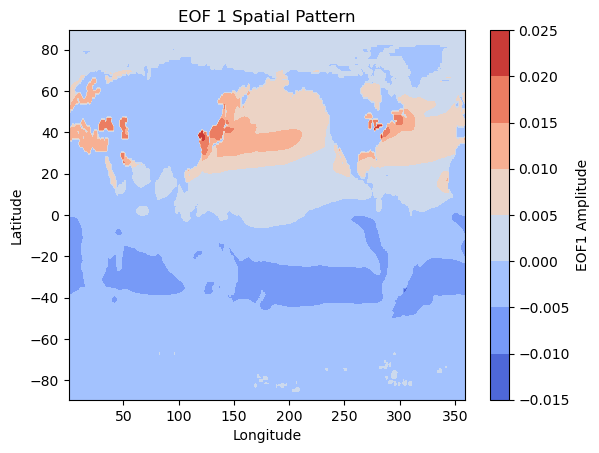

In [13]:
# Reshape EOF1 to spatial dimensions
eof1 = eofs[0, :].reshape(n_lat, n_lon)

plt.contourf(lon, lat, eof1, cmap='coolwarm')
plt.colorbar(label='EOF1 Amplitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('EOF 1 Spatial Pattern')
plt.show()


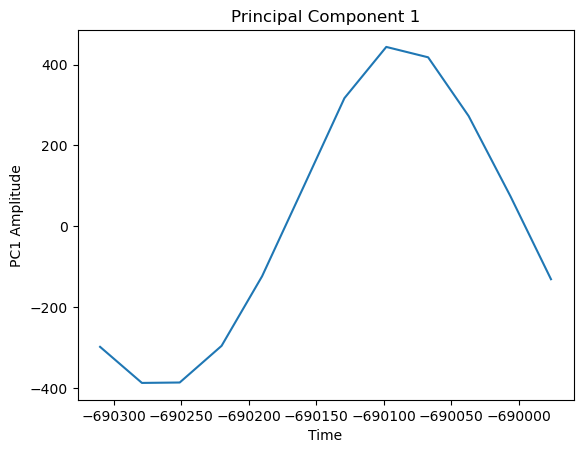

In [14]:
plt.plot(time, pcs[:, 0])
plt.xlabel('Time')
plt.ylabel('PC1 Amplitude')
plt.title('Principal Component 1')
plt.show()


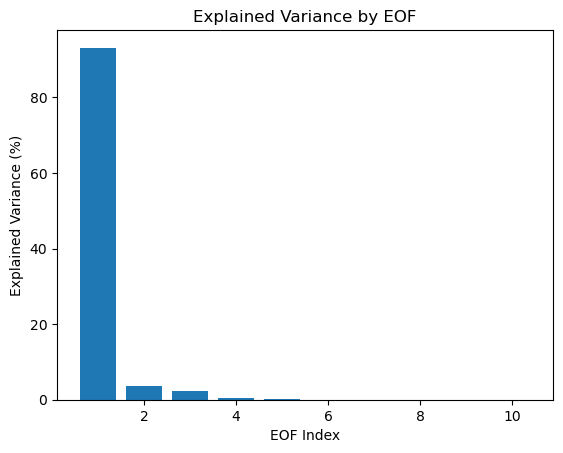

In [15]:
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100)
plt.xlabel('EOF Index')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by EOF')
plt.show()

Most of the variance is explained by the first EOF